# NOTES

- Applying `normalize_subset` to all records that contain `"(?i)microsoft|msft"` - i.e., a group of records that almost certainly all belong to MSFT - the algorithm works. This implies that the issue is indeed with the subgraph creation. I.e., the `"microsoft"` subgraph is being linked to other companies. Most likely, this is because there are 1 or 2 records with, e.g., `{"issuer_name": "microsoft", "cusip": apple's cusip}`. We 

# Prep

In [6]:
import polars as pl
from record_consolidation.graphs import (
    unconsolidated_df_to_subgraphs,
    _extract_consolidation_mapping_from_subgraph,
)
from record_consolidation.subgraph_post_processing.specific_algs.split_high_betweenness import (
    split_subgraph_where_necessary,
)
from record_consolidation.subgraph_post_processing.specific_algs.split_high_betweenness import (
    draw_graph,
)
import networkx as nx
from pathlib import Path

In [7]:
# votes: pl.DataFrame = access_db_table("raw_output", "votes")
votes: pl.DataFrame = pl.read_parquet("raw_votes.parquet")
COMPANY_COLS = pl.col(["issuer_name", "cusip", "isin", "figi"])
MEETING_COLS = pl.col(["issuer_name", "meeting_date", "cusip", "isin", "figi"])

In [8]:
def ps(subgraph: nx.Graph) -> None:
    for x in subgraph.nodes.data():
        print(x)

In [9]:
from typing import Iterable
from warnings import warn


def extract_specific_name_subgraph(
    connected_subgs: Iterable[nx.Graph], name: str
) -> nx.Graph:
    collected: list[nx.Graph] = []
    for subg in connected_subgs:
        for n in subg.nodes.data():
            if name.lower() in (n[0]).lower():
                collected.append(subg)
    collected = set(collected)
    if len(collected) == 0:
        raise ValueError(f"Could not find {name=} in connected_subgs.")
    if len(collected) > 1:
        alert_str = f"{len(collected)} subgraphs have {name=}.\n{[len(subg.nodes) for subg in collected]=}"
        warn(alert_str)
        return max(collected, key=lambda g: len(g.nodes))

        # raise ValueError(alert_str)
    return tuple(collected)[0]

# Extract SubGraphs

## Post Processing

In [10]:
post_processed_subgraphs = list(
    unconsolidated_df_to_subgraphs(
        votes.select(COMPANY_COLS),  # .head(100),
        weight_edges=True,
        connected_subgraphs_postprocessor=split_subgraph_where_necessary,
    )
)

In [11]:
cvx = extract_specific_name_subgraph(post_processed_subgraphs, "CHEVRON")

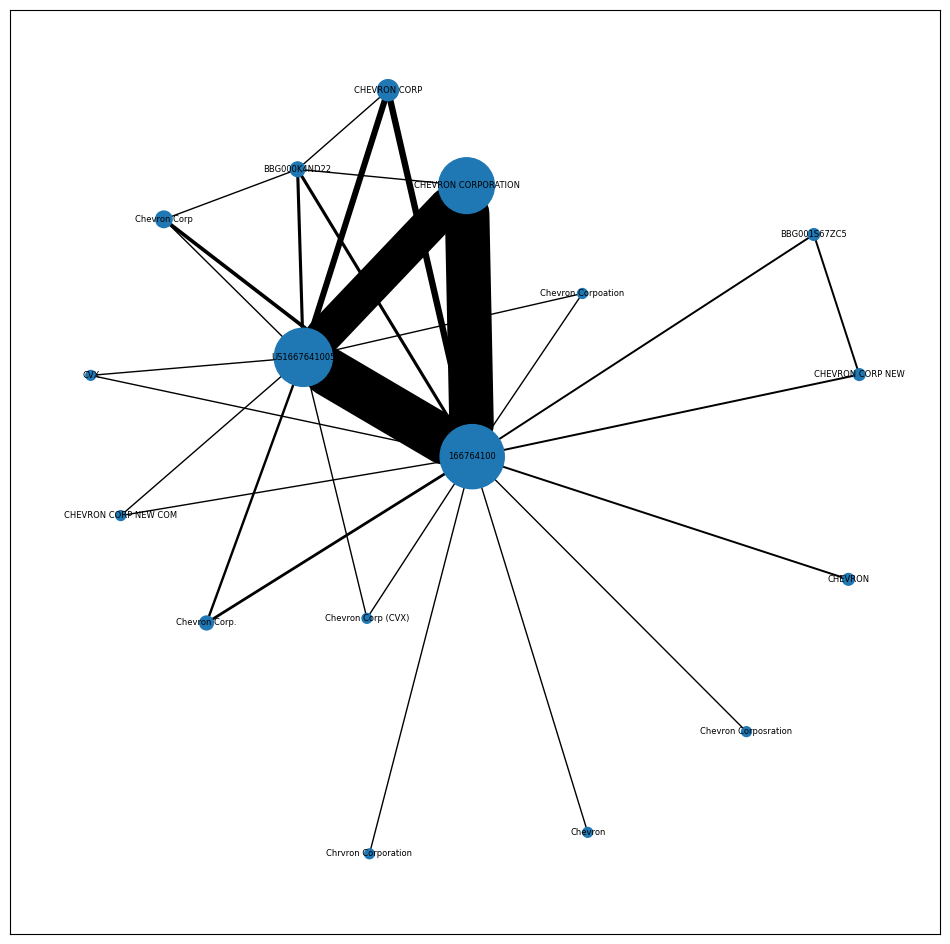

In [12]:
# ps(cvx)
draw_graph(cvx)

In [13]:
msft_subgraph = extract_specific_name_subgraph(post_processed_subgraphs, "microsoft")
mcds_subgraph = extract_specific_name_subgraph(post_processed_subgraphs, "mcdonald")
jpm_subgraph = extract_specific_name_subgraph(post_processed_subgraphs, "jpmorgan")

/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 3 subgraphs have name='mcdonald'.
[len(subg.nodes) for subg in collected]=[27, 1, 2]
  warn(alert_str)
/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 2 subgraphs have name='jpmorgan'.
[len(subg.nodes) for subg in collected]=[24, 1]
  warn(alert_str)


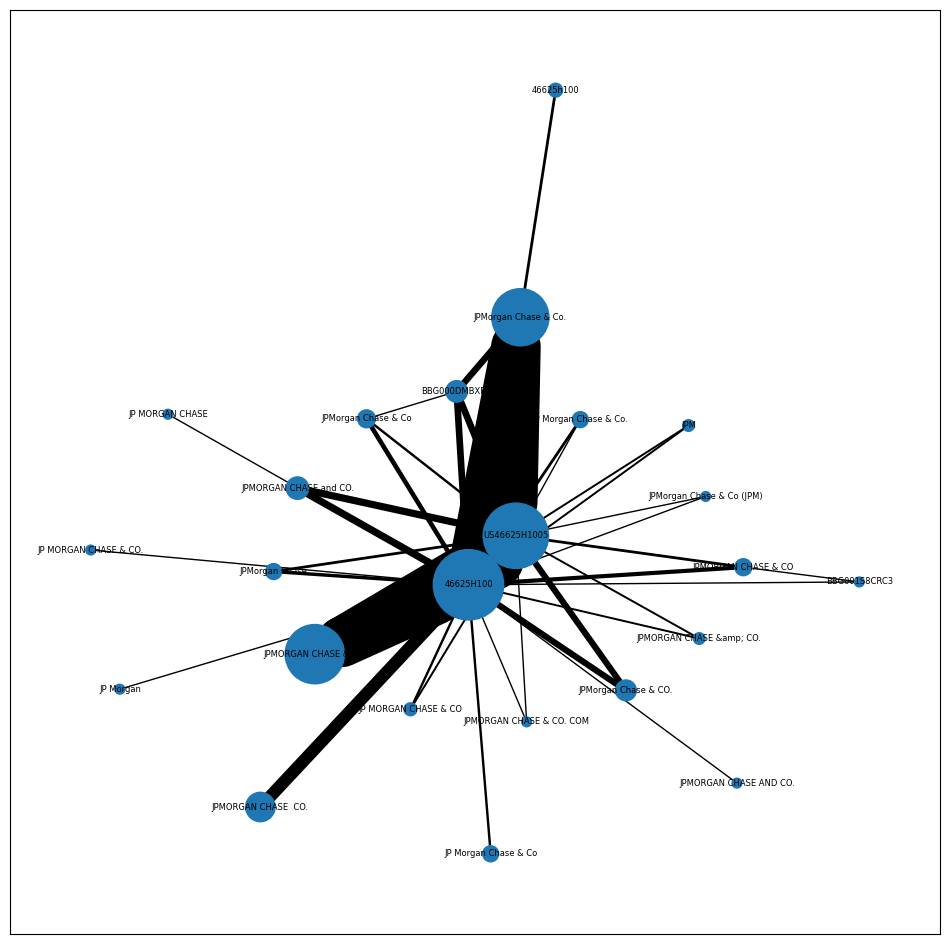

In [14]:
# ps(jpm_subgraph)
draw_graph(jpm_subgraph)

## No PostProcessing

In [15]:
subgraphs = list(
    unconsolidated_df_to_subgraphs(
        votes.select(COMPANY_COLS),
        weight_edges=True,
        connected_subgraphs_postprocessor=None,
    )
)

## Compare the two

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( MICROSOFT ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



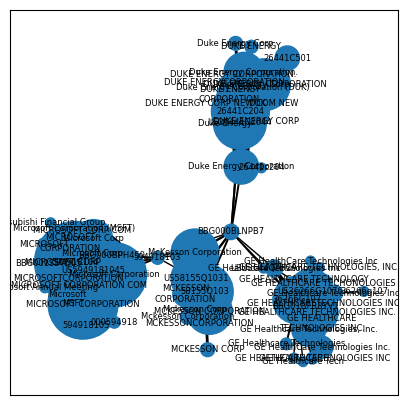

					 
 PROCESSED 



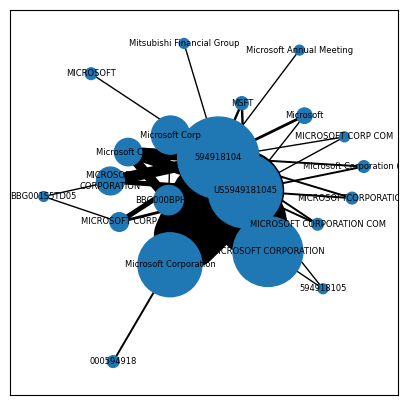

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( DUKE ENERGY ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



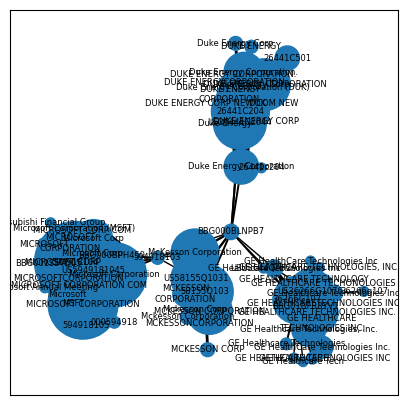

					 
 PROCESSED 



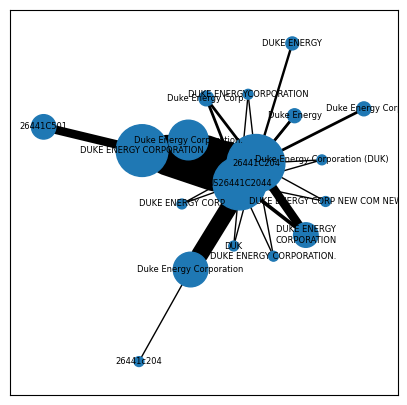

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( GE HEALTHCARE ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



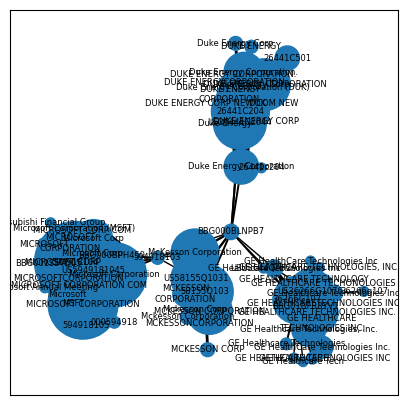

					 
 PROCESSED 



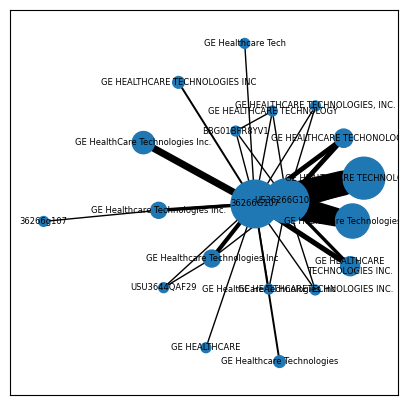

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( CHEVRON ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



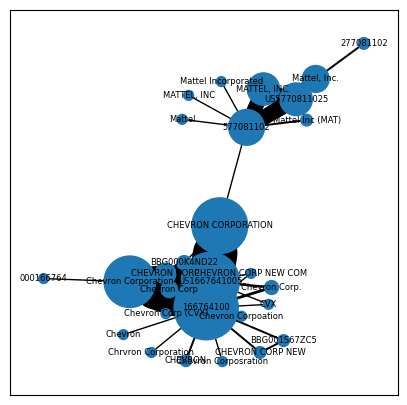

					 
 PROCESSED 



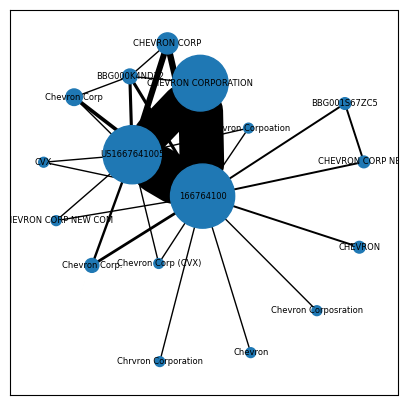

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( MATTEL ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 5 subgraphs have name='mattel'.
[len(subg.nodes) for subg in collected]=[1, 1, 1, 1, 1]
  warn(alert_str)


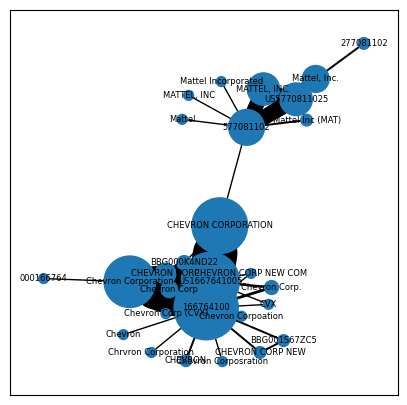

					 
 PROCESSED 



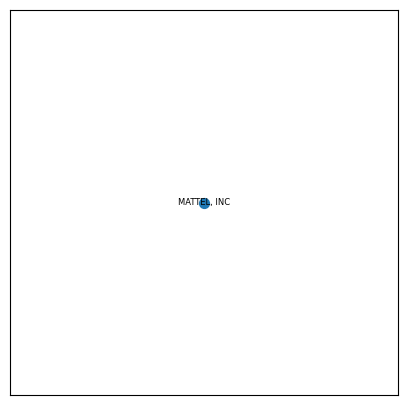

/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 2 subgraphs have name='jpmorgan'.
[len(subg.nodes) for subg in collected]=[24, 1]
  warn(alert_str)
/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 2 subgraphs have name='jpmorgan'.
[len(subg.nodes) for subg in collected]=[60, 1]
  warn(alert_str)


(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( JPMORGAN ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



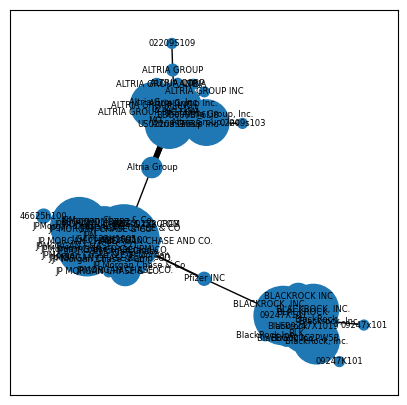

					 
 PROCESSED 



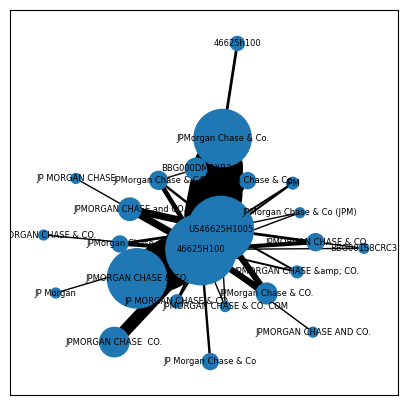

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( BLACKROCK ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 24 subgraphs have name='BlackRock'.
[len(subg.nodes) for subg in collected]=[3, 3, 3, 2, 4, 3, 5, 13, 3, 3, 2, 3, 3, 3, 3, 3, 14, 3, 2, 3, 3, 4, 3, 4]
  warn(alert_str)
/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_25199/942150125.py:18: UserWarning: 24 subgraphs have name='BlackRock'.
[len(subg.nodes) for subg in collected]=[3, 3, 4, 3, 2, 3, 3, 3, 2, 2, 4, 13, 3, 3, 5, 3, 4, 3, 60, 3, 3, 3, 3, 3]
  warn(alert_str)


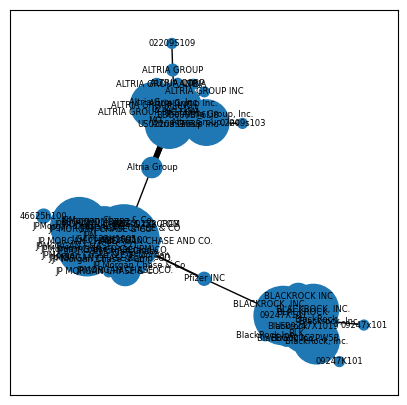

					 
 PROCESSED 



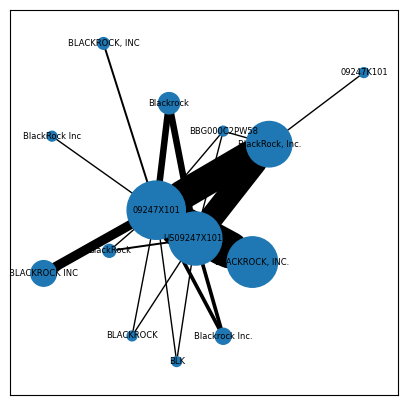

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( ALTRIA ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



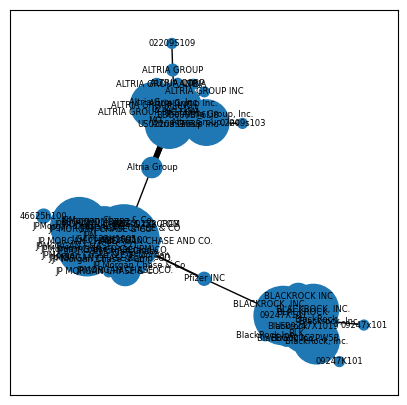

					 
 PROCESSED 



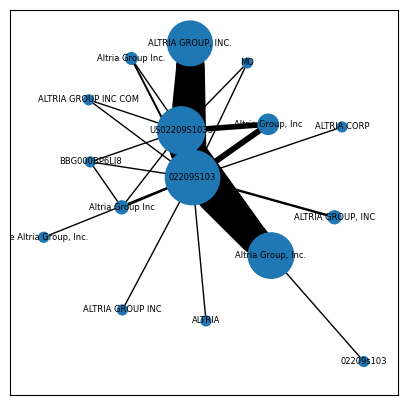

(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((( STARBUCKS ))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
					 
 UNPROCESSED 



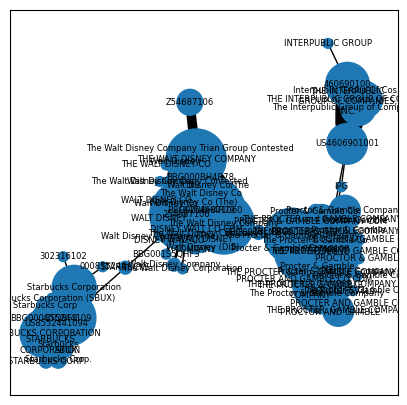

					 
 PROCESSED 



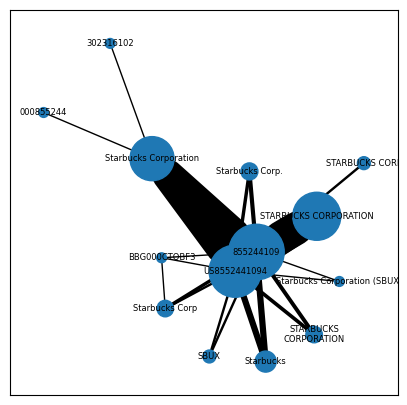

In [ ]:


erroneously_linked_cos = [
    "microsoft",
    "DUKE ENERGY",
    "GE HEALTHCARE",
    #
    "chevron",  # originally grouped (a)
    "mattel",  # originally grouped (a)
    #
    "jpmorgan",  # originally grouped (b)
    "BlackRock",  # originally grouped (b)
    "altria",  # originally grouped (b)
    #
    "starbucks",  # originally grouped (c)
    "proctor",  # originally grouped (c)
    "disney",  # originally grouped (c)
]
for co in erroneously_linked_cos:
    post_processed = extract_specific_name_subgraph(post_processed_subgraphs, name=co)
    post_processed_canonicals = _extract_consolidation_mapping_from_subgraph(
        post_processed
    )

    unprocessed = extract_specific_name_subgraph(subgraphs, name=co)
    unprocessed_canonicals = _extract_consolidation_mapping_from_subgraph(unprocessed)

    print("(" * 60, co.upper(), ")" * 60)

    # print("UNPROCESSED:\n")
    # ps(unprocessed)
    print("\t" * 5, "\n", "UNPROCESSED", "\n")
    draw_graph(unprocessed, size=5)
    # pprint(unprocessed_canonicals)

    # print("PROCESSED:\n")
    # ps(post_processed)
    print("\t" * 5, "\n", "PROCESSED", "\n")
    draw_graph(post_processed, size=5)
    # pprint(post_processed_canonicals)

# Conclusion(s) from comparing SubGraphs

- Algorithm works really well on subgraphs that need to be cut (tested with `betweenness_centrality` threshold of `0.06`). Still not perfect though.
- Not yet certain how well it performs on subgraphs which should *NOT* be cut.
- Some `Mattel` observations are cut too far / the alg is just performing strangely here:  

***UNPROCESSED CONSOLIDATION MAPPING***:
```json
{'cusip': {'000166764': '166764100',
           '166764100': '166764100',
           '277081102': '166764100',
           '577081102': '166764100'},
 'figi': {'BBG000K4ND22': 'BBG000K4ND22', 'BBG001S67ZC5': 'BBG000K4ND22'},
 'isin': {'US1667641005': 'US1667641005', 'US5770811025': 'US1667641005'},
 'issuer_name': {'CHEVRON': 'CHEVRON CORPORATION',
                 'CHEVRON CORP': 'CHEVRON CORPORATION',
                 'CHEVRON CORP NEW': 'CHEVRON CORPORATION',
                 'CHEVRON CORP NEW COM': 'CHEVRON CORPORATION',
                 'CHEVRON CORPORATION': 'CHEVRON CORPORATION',
                 'CVX': 'CHEVRON CORPORATION',
                 'Chevron': 'CHEVRON CORPORATION',
                 'Chevron Corp': 'CHEVRON CORPORATION',
                 'Chevron Corp (CVX)': 'CHEVRON CORPORATION',
                 'Chevron Corp.': 'CHEVRON CORPORATION',
                 'Chevron Corpoation': 'CHEVRON CORPORATION',
                 'Chevron Corporation': 'CHEVRON CORPORATION',
                 'Chevron Corposration': 'CHEVRON CORPORATION',
                 'Chrvron Corporation': 'CHEVRON CORPORATION',
                 'MATTEL, INC': 'CHEVRON CORPORATION',
                 'MATTEL, INC.': 'CHEVRON CORPORATION',
                 'Mattel': 'CHEVRON CORPORATION',
                 'Mattel Inc (MAT)': 'CHEVRON CORPORATION',
                 'Mattel Incorporated': 'CHEVRON CORPORATION',
                 'Mattel, Inc.': 'CHEVRON CORPORATION'}}
```

***PROCESSED CONSOLIDATION MAPPING***
```json
{'issuer_name': {'MATTEL, INC.': 'MATTEL, INC.'}}
```

# DEBUG: `atomize_subset` introducing nulls

E.g., we're starting with votes having 0 null `issuer_name` values, and ending up with 41 in the atomized subset.

Most likely an issue with the post-processing alg. I would guess that in some cases it's cutting connections to the point that there simply are no (e.g.) `issuer_name` values remaining in a cluster.

In [5]:
from record_consolidation.graphs import extract_normalized_atomic

atomized_subset = extract_normalized_atomic(
    votes.select(COMPANY_COLS),
    connected_subgraphs_postprocessor=split_subgraph_where_necessary,
)

## Try `normalize_subset` with post-processing
NOTE: should make this into a test
TODO: issue observed: there are nulls in the output. Not only that, some non-null values become null

In [2]:
from record_consolidation.df_consolidations import (
    normalize_subset,
    _consolidate_intra_field,
)

COMPANY_COLS_LIST = ["issuer_name", "cusip", "isin", "figi"]

In [13]:
normalized_w_postprocessing = normalize_subset(
    votes,
    connected_subgraphs_postprocessor=split_subgraph_where_necessary,
    cols_to_normalize=COMPANY_COLS_LIST,
)
normalized_w_postprocessing_no_consolidation_intra_fund = normalize_subset(
    votes,
    connected_subgraphs_postprocessor=split_subgraph_where_necessary,
    cols_to_normalize=COMPANY_COLS_LIST,
    _apply_consolidate_intra_field=False,
)
normalized_w_postprocessing_raw_subset = (
    normalize_subset(
        votes,
        connected_subgraphs_postprocessor=split_subgraph_where_necessary,
        cols_to_normalize=COMPANY_COLS_LIST,
        _return_joined_subset=True,
    )
    .with_columns(
        pl.col("canonical_row").struct.rename_fields(
            [
                "isin_CAN",
                "issuer_name_CAN",
                "cusip_CAN",
                "figi_CAN",
            ]
        )
    )
    .unnest("canonical_row")
)
consolidated_intra_field = _consolidate_intra_field(
    votes[COMPANY_COLS_LIST],
    connected_subgraphs_postprocessor=split_subgraph_where_necessary,
)
atomized_subset = normalize_subset(
    votes,
    connected_subgraphs_postprocessor=split_subgraph_where_necessary,
    cols_to_normalize=["issuer_name", "cusip", "isin", "figi"],
    _return_atomized_subset=True,
)

In [ ]:
votes.select(pl.col(COMPANY_COLS_LIST).is_null().sum())

In [ ]:
atomized_subset.select(pl.all().is_null().sum())

In [ ]:
consolidated_intra_field.select(pl.all().is_null().sum())

In [ ]:
normalized_w_postprocessing_no_consolidation_intra_fund.select(
    pl.col(COMPANY_COLS_LIST).is_null().sum()
)

In [ ]:
votes["issuer_name"].is_null().sum()

In [ ]:
normalized_w_postprocessing_raw_subset.filter(pl.col("issuer_name_CAN").is_null())

In [ ]:
votes.filter(
    normalized_w_postprocessing.select(pl.col("issuer_name").is_null()).to_series()
)[COMPANY_COLS_LIST]

In [ ]:
votes.filter(
    normalized_w_postprocessing_raw_subset.select(
        pl.col("issuer_name").is_null()
    ).to_series()
)[COMPANY_COLS_LIST]

In [ ]:
votes.filter(
    consolidated_intra_field.select(pl.col("issuer_name").is_null()).to_series()
)[COMPANY_COLS_LIST]

In [ ]:
normalized_w_postprocessing.filter(pl.col("issuer_name").is_null())

In [ ]:
normalized_w_postprocessing_raw_subset[COMPANY_COLS_LIST].select(
    pl.all().is_null().sum()
)

In [ ]:
normalized_w_postprocessing[COMPANY_COLS_LIST].select(pl.all().is_null().sum())

In [ ]:
consolidated_intra_field[COMPANY_COLS_LIST].select(pl.all().is_null().sum())

In [ ]:
votes[COMPANY_COLS_LIST].select(pl.all().is_null().sum())

In [ ]:
normalized_w_postprocessing_raw_subset.with_columns(
    pl.col("canonical_row").struct.rename_fields(
        [
            "isin_CAN",
            "issuer_name_CAN",
            "cusip_CAN",
            "figi_CAN",
        ]
    )
).unnest("canonical_row")

In [ ]:
consolidated_intra_field

In [ ]:
normalized_w_postprocessing["canonical_row"][0].keys()

In [18]:
normalized_w_postprocessing.with_columns(
    pl.col("canonical_row").struct.rename_fields(
        [
            "isin_CAN",
            "issuer_name_CAN",
            "cusip_CAN",
            "figi_CAN",
        ]
    )
).unnest("canonical_row").filter(
    pl.col("issuer_name").str.contains("(?i)amazon")
).write_csv(
    "investigating_null_canonicals-amzn.csv"
)

In [ ]:
normalized_w_postprocessing

In [ ]:
extract_specific_name_subgraph(post_processed_subgraphs, "")

In [ ]:
from datetime import datetime


compare_dataframes(
    votes,
    normalized_w_postprocessing,
    name1="votes",
    name2="normalized_w_postprocessing",
    comparison_export_path=Path(f"comparison_{datetime.now().isoformat()}.csv"),
)

In [ ]:
votes.head()

In [ ]:
normalized_w_postprocessing.head()